In [134]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)
from collections import Counter
import operator
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds as svd

from sklearn.decomposition import NMF

from sklearn.datasets import fetch_20newsgroups
from scipy.sparse.linalg import norm
from scipy.sparse import csr_matrix as matrix

# question 4
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import math

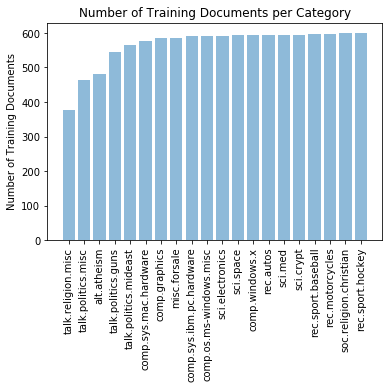

In [10]:
#Question 1
#Histogram containing the total number of training documents per category.

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
targets = newsgroups_train.target
target_names = newsgroups_train.target_names
target_frequency = Counter(targets)
target_frequency = sorted(target_frequency.items(), key=operator.itemgetter(1))
labels = []
freqs = []

for e in target_frequency:
    labels.append(target_names[e[0]])
    freqs.append(e[1])
# print(X)
# print(Y)

plt.bar(labels, freqs, align='center', alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of Training Documents")
plt.title("Number of Training Documents per Category")

plt.show()


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(newsgroups_train.data[:2])
# print(vectorizer.get_feature_names(), X)

In [5]:
import re
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words('english'))

def no_num_tokenizer(document):
    unlemmatized_words = [word for word in re.split('[^a-zA-Z]+', document) if len(word)>2]
    words = [lemmatizer.lemmatize(word) for word in unlemmatized_words if word not in stop_words]
    return words

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\meet1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meet1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This is a really bad lemmatizer. It does nothing except for changing plurals to their singular form

In [119]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer

vectorizer = CountVectorizer(stop_words=None, tokenizer=no_num_tokenizer, min_df=3)
tf_train = vectorizer.fit_transform(newsgroups_train.data)

tf_test = vectorizer.transform(newsgroups_test.data)

In [121]:
df_train = (tf_train>0).sum(axis=0).flatten()
idf_train = np.log(tf_train.shape[0]/df_train)+1

# df_test = (tf_test>0).sum(axis=0).flatten()
# idf_test = np.log(tf_train.shape[0]/df_train)+1
# https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest

df_test = (tf_test>0).sum(axis=0).flatten()
# idf_test = np.log(tf_train.shape[0]/df_test)+1

In [8]:
tf_idf_train = tf_train.copy().astype(float)

for i in range(tf_train.shape[1]):
    tf_idf_train[:,i] = tf_train[:,i] * idf_train[0,i]

print(tf_idf_train.shape)

(11314, 29930)


In [122]:
tf_idf_test = tf_test.copy().astype(float)

for i in range(tf_test.shape[1]):
    tf_idf_test[:,i] = tf_test[:,i] * idf_train[0,i]

print(tf_idf_test.shape)

(7532, 29930)


In [123]:
# np.random.shuffle(tf_idf_train)

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [124]:
X_train = tf_idf_train
X_test = tf_idf_test

k = 50

Uk, s, VT = svd(X_train,k=k) #X is TF-IDF matrix from problem 2
# s[::-1].sort() # use this method or the one below

# Vk = VT.transpose()


X_train_lsa = Uk.dot(np.diag(s).dot(VT))

In [54]:
#NMF
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
model = NMF(n_components=k, init='random', random_state=0)
W = model.fit_transform(X_train)
H = model.components_

X_train_nmf = np.matmul(W, H)

violation: 1.0
violation: 4.264327833779457
violation: 0.5377123473627514
violation: 0.2936458792338207
violation: 0.2153865293376489
violation: 0.17126887235773475
violation: 0.11756693762881346
violation: 0.08241238581648522
violation: 0.06043244636435165
violation: 0.04658140951022444
violation: 0.03901704464386055
violation: 0.03101849531940079
violation: 0.024854401923134588
violation: 0.021039475441079467
violation: 0.01831309344784843
violation: 0.01633033136505475
violation: 0.014800379165482961
violation: 0.013850697130222564
violation: 0.01325009687380042
violation: 0.013034828677786806
violation: 0.012964238075638604
violation: 0.01328575720487737
violation: 0.014935942632840506
violation: 0.015620699691475755
violation: 0.013746291135790886
violation: 0.011106366808165092
violation: 0.009223531215810377
violation: 0.007790206328873399
violation: 0.006753113176150943
violation: 0.005952079476283421
violation: 0.005349815048906964
violation: 0.004793834674298556
violation: 0.

In [108]:
# n,m = X_train.shape

# fnorm_lsa = 0.0
# fnorm_nmf = 0.0

# for i in range(n):
    
#     print(i)
#     for j in range(m):
#         fnorm_lsa += (X_train[i,j]-X_train_lsa[i,j])**2
#         fnorm_nmf += (X_train[i,j]-X_train_nmf[i,j])**2

# ((matrix(X_train_lsa)-matrix(X_train))**2).sum()

# X_train_nmf.shape

(11314, 29930)

In [128]:
X_train_reduced = X_train.dot(VT.T)
X_test_reduced = X_test.dot(VT.T)

In [131]:
#Problem 4 SVM

Train_X = X_train_reduced
Train_Y = newsgroups_train.target
Test_X = X_test_reduced
Test_Y = newsgroups_test.target

In [132]:
soft_svm = SVC(gamma = 0.0001)
soft_svm.fit(Train_X, Train_Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [143]:
soft_svm.score(Train_X, Train_Y)

0.5167933533675093

In [138]:
Y_predict_soft = soft_svm.predict(Test_X)
soft_accuracy = soft_svm.score(Test_X, Test_Y)
soft_precision, soft_recall, soft_f1 = precision_score(Test_Y, Y_predict_soft, average='micro'), recall_score(Test_Y, Y_predict_soft, average='micro'), f1_score(Test_Y, Y_predict_soft, average='micro')
# soft_fpr, soft_tpr, soft_thresholds = roc_curve(Test_Y, Y_predict_soft)
print("The soft SVM accuracy is:", soft_accuracy)
print("Soft SVM f1 score:", soft_f1)

The soft SVM accuracy is: 0.459506107275624
Soft SVM f1 score: 0.459506107275624


In [141]:
hard_svm = SVC(gamma = 1000)
hard_svm.fit(Train_X, Train_Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1000, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [142]:
Y_predict_hard = hard_svm.predict(Test_X)
hard_accuracy = hard_svm.score(Test_X, Test_Y)
hard_precision, hard_recall, hard_f1 = precision_score(Test_Y, Y_predict_hard, average='micro'), recall_score(Test_Y, Y_predict_hard, average='micro'), f1_score(Test_Y, Y_predict_hard, average='micro')
# hard_fpr, hard_tpr, hard_thresholds = metrics.roc_curve(Test_Y, Y_predict_hard)

print("The hard SVM accuracy is:", hard_accuracy)
print("Hard SVM f1 score:", hard_f1)

The hard SVM accuracy is: 0.054168879447689854
Hard SVM f1 score: 0.054168879447689854


In [147]:
best_score = 0.0
best_gamma = None
best_classifier = None

kf = KFold(n_splits=5)
for i in range(-3, 4, 1):
    scores = []
    gamma = pow(10, i)
    for train_index, test_index in kf.split(Train_X):
        X_train, X_test = Train_X[train_index], Train_X[test_index]
        y_train, y_test = Train_Y[train_index], Train_Y[test_index]
        clf = SVC(gamma = gamma)
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    average_score = np.mean(scores)
    print(gamma, average_score)
    if average_score > best_score:
        best_score = average_score
        best_gamma = gamma
        best_classifier = clf

print("The best gamma hyper parameter is: " + str(best_gamma))
print("The best mean score is: " + str(score))

The best gamma hyper parameter is: 0.01


NameError: name 'score' is not defined

In [ ]:
best_predict = best_classifier.predict(Test_X)
best_accuracy = best_classifier.score(Test_X, Test_Y)
precision, recall, f1 = precision_score(Test_Y, best_predict, average='micro'), recall_score(Test_Y, best_predict, average='micro'), f1_score(Test_Y, best_predict, average='micro')
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, best_predict)